## Case Study 


In this notebook we are going to perform different experiments, at different levels: events, schedules, performances and tickets. Furthermore, this notebook allows us to select:
 - 1. The city to perform the study to
 - 2. The categories (e.g. Music, Film, Books ...) that we want to explore at different levels. 
 - 3. The month that we want to explore further (e.g. August) over the years. 

These values are introduced in the **Parameters Selection** section of this notebook. 
 
**Prerequisite**: You need to have run (at least once) the **Generate_List_Dataframes** notebook, and have all the dataframes (df_places, df_new_events, df_p, dp_schedule_revenue, df_tickets, df_p_properties, etc.)

As follows we have the schema of **events data**.

The most importants remarks are:

    -1. One event can have more than 1 schedule
    -2. One schedule can last more than a day: start_ts and end_ts, could compromise a period of several days
    -3. One scheudle can have more than 1 performance
    -4. All performances of each schedule are always in the same place (schedule--> place_id). 
    -5. A performance has a timestamp (ts)
    -6. A performance can have several tickets
    -7. A ticket can have max_price and min_price

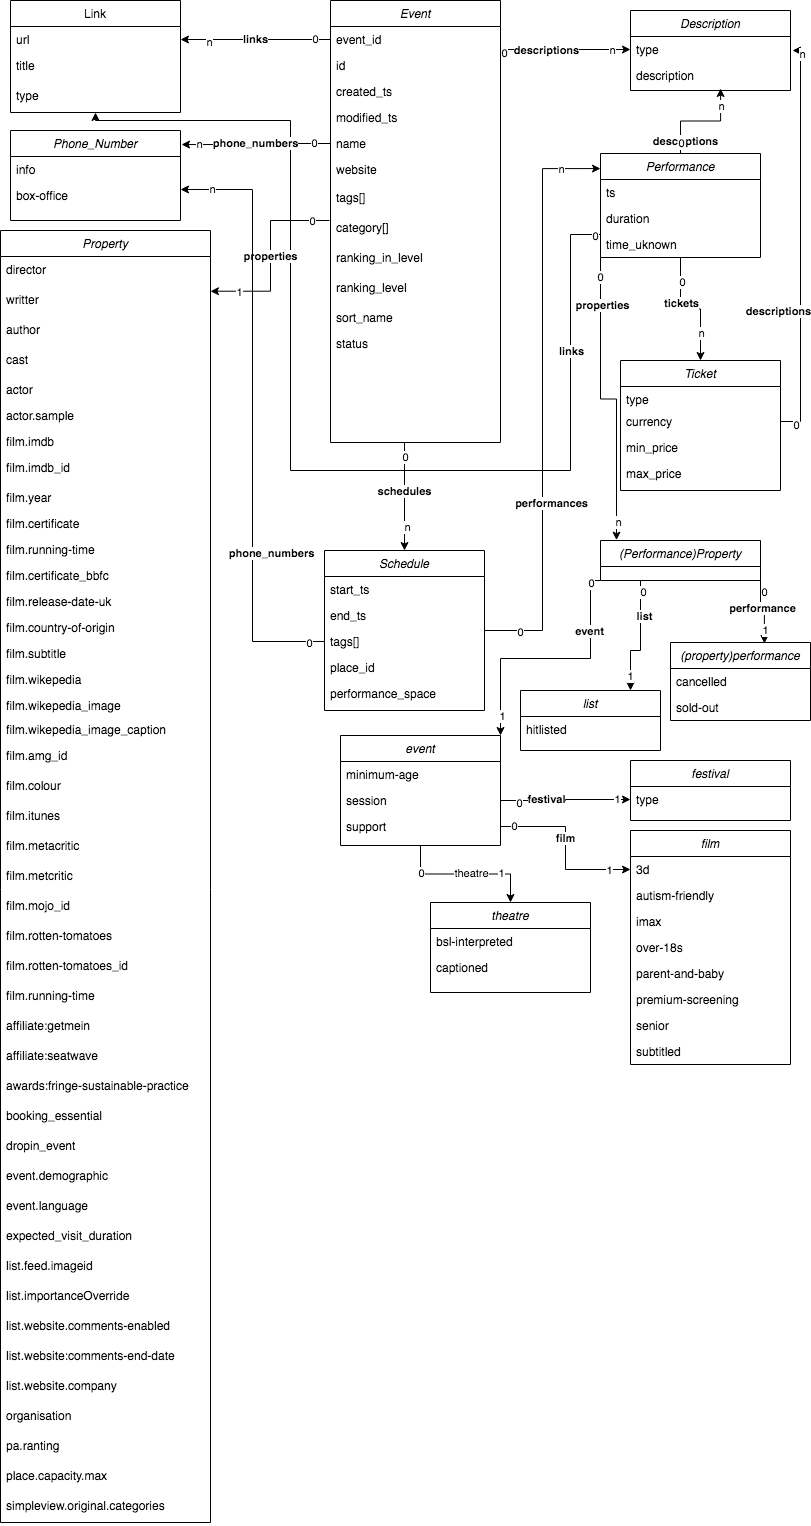

## Experiments

This is the list of experiments that we are going to perform. 

**Important**: In order to run this notebook you need to have run the **Generating_List_DataFrames** notebook. Since, this notebook assume that we have already all the dataframes stored (*df_places, df_new_events, df_p, dp_schedule_revenue, df_tickets, df_p_properties*) in the "dataframe" directory. 

- 0. **Loading dataframes**
    - 1.1. Loading Places dataframe
    - 1.2  Loading Events dataframe
    
- 1. **Working at EVENT Level**
    - 1.1 Exploring Category Events
        - 1.1.a Frequency of Events per Category - wihout taking account the frequency of each event across snapshots
        - 1.1.b Frequency of Events per Category - taking account the frequency of each event across snapshots
        - 1.1.c Bar Plot of Frequency of Events per Category -taking account the frequency of each event across snapshots
    - 1.2 Exploring Period of times
        - 1.2.a Frequency of events grouped by categories starting at the same period of time
        - 1.2.b Frequency of events grouped by categories ending at the same period of time
        - 1.2.c Gantt chart of events grouped by categories in different periods
   
    
- 2. **Working at SCHEDULES level**: These are performed across all the dates available (full period) & for the selected month over the years. 
    - Preparation: Filter schedules by the selected city
    - 2.1 Schedules Frequency per Category at the selected city
    - 2.2 Histograms of Schedules Frequency per Category at the selected city
    - 2.3 Schedules Revenues per Category at the selected city
    - 2.4 Histograms of Schedules Revenue per Category  at the selected city
    
    
- 3. **Working at PERFORMANCES level**: These are performed across all the dates available (full period) & for the selected month over the years. 
    - Preparation: Filter performances by the selected city
    - 3.1 Performances Frequency per Category at the selected city
    - 3.2 Histograms of Performances Frequency per Category at the selected city
    - 3.3 Histogram of Sold Out Performances Frequency at the selected city
    - 3.4 Histogram of Cancelled Performances Frequency at the selected city
    - 3.5 Maps of Performances Places
        - 3.5.1 Plot of Performances Places
        - 3.5.2 Plot of Performances Places Frequency
        - 3.5.3 Selecting the Festival Month and Plotting Performances Places and their Frequency
        - 3.5.4 Selecting the Festival Month and Plotting Performances Places and their Frequency **by selected Category**
           
  
    
- 4. **Working at Tickets level**: These are performed across all the dates available (full period) & for the selected month over the years. 
    - Preparation: Filter tickets by the selected city
    - 4.1 Tickets Frequency per Category at the selected city
    - 4.2 Histograms of Tickets Frequency per Category and Types at the selected city
    - 4.3 Histogram of Free Tickets Frequency per Category at the selected city
    
    
- 5. **LDA Topic Modelling**: This could take a long time to run depending on the city selected. 
       
     - 5.1 Calculating Embeddings from Events and Performances Descriptions
     - 5.2 Calculating LDA Topics using BertTopic:
         - Two options available: with and without HDBSCAN. 
     - 5.3 Comparing LDA Topics with categories
 

## Importing libraries 

In [ ]:
import json
import pandas as pd
import plotly.express as px
import os
import pickle
import plotly.graph_objects as go
import numpy as np
from dateutil.relativedelta import relativedelta
from os import listdir
from os.path import isfile, join
import datetime
from scipy import stats
import datetime
import plotly.io as pio

#pio.renderers.default = "browser"
import plotly.offline as pyo

## Dataframe & Models Directories

**IMPORTANT**: This notebook assumes that you have alredy generated all the necessary dataframes and stored them in a directory. If not, run first **Generate_List_Dataframes* notebook. 

In [ ]:
### Change those if you want to use a different path or folder names. 
### For the dataframe_path, as you did for Generate_List_Dataframes notebook. 
dataframe_path="./dataframe"

## This path will be used in section 5. 
models_path="./models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
    
#This path will be used in section 3 - maps
html_path="./html_figures"
if not os.path.exists(html_path):
    os.makedirs(html_path)

## Functions 

In [ ]:
def month_to_string(month):
        if month == 1 :
            month_string="January"
        elif month == 2:
            month_string="February"
        elif month == 3:
            month_string= "March"
        elif month == 4:
            month_string="April"
        elif month == 5:
            month_string="May"
        elif month == 6:
            month_string="June"
        elif month ==7 :
            month_string="July"
        elif month == 8:
            month_string="August"
        elif month ==9:
            month_string="September"
        elif month == 10:
            month_string="October"
        elif month ==11:
            month_string="November"
        else:
            month_string="December"
        return month_string
    
        


In [ ]:
def check_city(city):
    if city not in city_l:
        print("Error! Change this city name: %s. Unfortunatly this one is not in the currently available" % city)
        print("Go to the previous cell and change the name of the city, and run it again")
    else:
        print("Ok! You are going to study %s" %city)

In [ ]:
def check_categories(list_categories):
    error=0
    for c in list_categories:
        if c not in category_l:
            print("Error! Change this category name: %s. Unfortunatly this one is not in the currently available" % c)
            print("Go to the previous cell and change the name of this category, and run it again")
            error = 1
 
    if error == 0: 
        print("Ok! You are going to study %s" % list_categories)

In [ ]:
def dataframe_groupby_size(df, column_list, rename, level=None, city=None, period="full"):
    if len(column_list)==1:
        column=column_list[0]
        df_v1=df.groupby([column]).size().reset_index()
        df_v1=df_v1.rename(columns={0: rename}).sort_values(by=[rename], ascending=False)
        if city:
            title= level+" " + rename+ " per "+ column + " at " +city
            if period!= "full":
                title = title + " for the month of " + month_string + " over the years"
            fig_scatter=px.scatter(df_v1, x=column,y=rename, color=rename, size=rename, size_max=50, title=title)
            fig_bar= px.bar(df_v1, x=column, y=rename, color=column, barmode='group', title=title)
            
           
        else:
            title= level+" " + rename+ " per "+ column 
            if period != "full":
                title = title + " for the month of " + month_string + " over the years"
            fig_scatter=px.scatter(df_v1, x=column,y=rename, color=rename, size=rename, size_max=50, title=title)
            fig_bar= px.bar(df_v1, x=column, y=rename, color=column, barmode='group', title=title)
            

        return df_v1, fig_scatter, fig_bar
    else:
        df_v1=df.groupby(column_list).size().reset_index()
        df_v1=df_v1.rename(columns={0: rename})
        return df_v1
    

In [ ]:
def dataframe_groupby_sum(df, list_column, column2, level, rename=None, city=None, period="full"):
    if len(list_column)==1:
        column1=list_column[0]
        df_v1=df.groupby([column1])[column2].sum().reset_index()
        if not rename:
            df_v1=df_v1.sort_values(by=[column2], ascending=False)
            title=level+" " + column2+ " per "+ column1        
            if period !="full":
                 title=title + " for the month of " + month_string + " over the years"
                
            fig_scatter=px.scatter(df_v1, x=column1,y=column2, color=column2, size=column2, size_max=50, title=title )
            fig_bar= px.bar(df_v1, x=column1, y=column2, color=column1, barmode='group', title=title)
            return df_v1, fig_scatter, fig_bar
        else:
            title=level+" " + rename+ " per "+ column1 + " at " + city  
            if period != "full":
                 title=title + " for the month of " + month_string + " over the years"
                
            df_v1=df_v1.rename(columns={column2: rename}).sort_values(by=[rename], ascending=False).reset_index()
            fig_bar = px.bar(df_v1, x=column1, y=rename, color=column1, barmode='group', title= title)
            return df_v1, fig_bar
    else:
        df_v1=df.groupby(list_column)[column2].sum().reset_index()
        df_v1=df_v1.rename(columns={column2: rename}).sort_values(by=[rename], ascending=False).reset_index()
        return df_v1
       

In [ ]:
def fig_histogram_color(df, x, column, level, city, y=None, period="full"):
    if not y:
        title= "Histogram of " + level.lower() + " per "+ column + " at " + city
        if period !="full":
            title= title + " for the month of " + month_string  + " over the years"         
        fig=px.histogram(df, x=x, color=column, title=title)
        fig.update_xaxes(
        dtick="M1",
        ticklabelmode="period")
        return fig
    else:
        title= "Histogram of "+ level.lower()+ " " + y + " per "+ column + " at " + city
        if period != "full":
            title= title + " for the month of " + month_string  + " over the years"
        #nbins=12*num_years -->12*6
        fig= px.histogram(df, x=x,y=y, color=column,  title=title, nbins=72)
        fig.update_xaxes(
        dtick="M1",
        ticklabelmode="period")
        return fig

In [ ]:
def fig_histogram_subtype(df, x, column, y, category,  level, city, period='full'):
    df_v1= df[df[column].isin([category])].sort_values(by=[x], ascending=True).reset_index()
    title="Histogram of "+ category + " " + level.lower() + " " + y + " at " + city
    if period!="full":
        title=title + " for the month of " + month_string + " over the years"
    #nbins=12*num_years --> 12*6
    fig=px.histogram(df_v1, x=x,y=y, title=title,  nbins=72)
    fig.update_xaxes(
    dtick="M1",
    ticklabelmode="period")
    return fig
     

In [ ]:
def clean_documents(text):
    text1 = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE) # remove email
    text1 = re.sub(r'http\S+', '', text1, flags=re.MULTILINE) # remove web addresses
    text1 = re.sub("\'", "", text1) # remove single quotes
    text2 = remove_stopwords(text1)
    text2= re.sub('\s+(a|an|and|the|The|A|An|And)(\s+)', '\2', text2) # removes the whitespace
    
    return text2

## Original dataset

The original dataset are 9 files, which are snapshots of a serie events and places during a period of 6 months each:

- sample_20171101.json: snapshot period: 2017-11-01 to 2018-05-01
- sample_20180501.json: snapshot period: 2018-05-01 to 2018-11-01
- sample_20181101.json: snapshot period: 2018-11-01 to 2019-05-01
- sample_20190501.json: snapshot period: 2019-05-01 to 2019-11-01
- sample_20201101.json: snapshot period: 2019-11-01 to 2020-05-01
- sample_20211101.json: snapshot period: 2020-05-01 to 2020-11-01
- sample_20191101.json: snapshot period: 2020-11-01 to 2021-05-01
- sample_20210501.json: snapshot period: 2021-05-01 to 2021-11-01
- sample_20200501.json: snapshot period: 2021-11-01 to 2022-05-01

And we "transformed" them into a serie of datataframes using the **Generating_List_DataFrames** notebook. 

**Important**: An event can be present across more than one snaptshots (this means that is present in more than one file). To deal with **this issue**, we had "merged" together the information of the repeated events. During the merging phase, we got rid off of the repeated information, while preseving the parts that are not repeated (e.g. schedules, tags). 

Furthermore, we have also created three new columns at event level:
- period_start: To capture the period of the snapshot in which an event has started. 
- perod_end: To capture the period of the snapshot in which an event has ended.
- frequency_event: To capture the number of times an event appears across periods of snapshots. 

Those are initilliazed as follows:
- Event's period_start are initiliazed with the period indicated in their snapshot file names (e.g. sample_20180501 --> 20180501)
- Event's period_end are initiliazed period_start + 6 months
- Event's frequency_event are initialized with 1. In case an event is repeated across several snapshot periods, this information will change. 


In [ ]:
df_places = pd.read_pickle(dataframe_path+"/df_places")
df_events = pd.read_pickle(dataframe_path+"/df_new_events")

#### Visualizing the places dataframe

In [ ]:
df_places[0:2]

#### Visualizing the events dataframe

In [ ]:
df_events[0:2]

In [ ]:
### These are important for selecting in the next section the configuration parameters

In [ ]:
city_l=list(df_places.town.unique())
category_l=list(df_events.category.unique())
cities_available=', '.join(city_l)
categories_available=', '.join(category_l)

## Parameters Selection

**IMPORTANT** You need to indicate the following 3 parameters. 

These allows you to select the city, the list of categories to study, and the specific month to perform further analyses. 

Bellow you have the list of cities and categories available. 

In [ ]:
### This list the cities available
cities_available

In [ ]:
### This list the categories available
categories_available

##### 1. Indicate the **city** that you want to perform the experiments to. Above you have the list of cities available


In [ ]:
### Introduce here the name of the city that you want to study
city="Edinburgh"

In [ ]:
### Checking if the city has been selected correctly 
check_city(city)

##### 2. Indicate the **categories** that you want to explore at different levels. Above you have the list of categories available. 


In [ ]:
### Introduce here the name of the city that you want to study
list_categories=["Music", "Visual art", "Film", "Days out", "Books", "Comedy", "Theatre"]

In [ ]:
### Checking if the categories have been selected correctly 
check_categories(list_categories)

##### 3. Indicate the month (number between 1 to 12) that you want to explore further (e.g. the month of a festival) across the years. 

In [ ]:
### Introduce the number of the month that you want to explore further - e.g month of a festival.
month=8

In [ ]:
if month < 0 or month > 12:
    print("Go the previous cell, and change the number of the month")

##### Further automatic configurations

You do not need to do anything in the next cell, just run it. 

In [ ]:
### do not change nothing here

month_string=month_to_string(month)
if city=="St Andrews":
    city_sort_name="sta"
else:
    city_sort_name=city.lower().replace(" ","")

## 1. Working at Event level

- **1 Event can have 1 to N Schedules**
- 1 Schedule is in 1 Place
- 1 Schedule can have 1 to N Performances
- 1 Peformance can have 1 to N Tickets
- 1 Ticket has a max_price, min_price, currency.

**Important**: At **event level we dont have information of the places**. So we can not filter events by city, neither by scheduling start/end times. But we do have the information to which snapshot period (period start and period end) each event belong to, along with the frequency of the repetition of each event across periods. 

### 1.1  Exploring Category Events

### 1.1.a Frequency of Categories 

We are going to calculate the frequency of each category. Here we are **NOT GOING TO TAKE INTO ACCOUNT** the frequency in which an event is repeated across periods. 

In [ ]:
g_category, fig_scatter, fig_bar=dataframe_groupby_size(df_events, ['category'], 'frequency', 'Events')
fig_scatter.show()

In [ ]:
fig_bar.show()

### 1.1.b  Frequency of categories taking account the frequency of each event. 

We are going to calculate the frequency of each category **TAKE INTO ACCOUNT** the frequency in which an event is repeated across periods.

In [ ]:
g_category_v2, fig_scatter, fig_bar=dataframe_groupby_sum(df_events, ['category'], 'frequency_event', 'Events')
fig_scatter.show()

In [ ]:
fig_bar.show()

### 1.2 Exploring Period of times

Remember: An event has two columns with information about its snapshots period of times

- period_start: To capture the period in which an event has started. 
- perod_end: To capture the period in which an event has ended.

Therefore, our events can start and ends at different periods of time - some examples are here:
- We have events that start in 2018-05-01 and end 2018-11-01
- We have events that start in 2018-05-01 and end 2019-05-01
- We have events that start in 2018-05-01 and end 2021-05-01
- We have envents that start in 2019-05-01 and end 2021-05-01
- We have envents that start in 2018-11-01 and end 2022-05-01
....

### 1.2.a Frequency of events grouped by categories starting at the same period of time

In [ ]:
g_category_start =dataframe_groupby_size(df_events, ['category', 'period_start'], 'frequency', 'Events')
g_category_start=g_category_start.sort_values(by=['frequency'], ascending=False)
px.scatter(g_category_start, x="category",y='period_start', color='frequency', size="frequency", size_max=60, title="Events frequency per category starting at the same period of time")


### 1.2.b Frequency of events grouped by categories ending at the same period of time

In [ ]:
g_category_end =dataframe_groupby_size(df_events, ['category', 'period_end'], 'frequency', 'Events')
g_category_end=g_category_end.sort_values(by=['frequency'], ascending=False)
px.scatter(g_category_end, x="category",y='period_end', color='frequency', size="frequency", size_max=60, title="Events frequency per category ending at the same period of time")

### 1.2.c Gantt chart of events grouped by categories in different periods

In [ ]:
fig = px.timeline(df_events, x_start="period_start", x_end="period_end", y="category", color="category")
fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_layout(title="Gantt chart of events grouped by categories in different period of time")
fig.update_xaxes(dtick="M2", ticklabelmode="period")
fig.show()

## 2. Working at Schedule Level 

We have pre-calculated the revenue at the schedule level. 
Originally this information was not available. 

    1 Event can have 1 to N Schedules.
    1 Schedule is in 1 Place
    1 Schedule can have 1 to N Performances
    1 Peformance can have 1 to N Tickets
    1 Ticket has a max_price, min_price, currency.




### Preparation: Filter schedules by the selected city

In [ ]:
df_schedule_revenue = pd.read_pickle(dataframe_path+"/df_schedule_revenue")

## Filter by city schedules
df_schedule_revenue_city=df_schedule_revenue[df_schedule_revenue['town'].isin([city])]
len(df_schedule_revenue)


In [ ]:
### df_schedule_revenue_city_festival : Just selecting the schedules starting at a particular month across years.
tz_info = df_schedule_revenue_city.iloc[0].start_ts.tzinfo
date1 = datetime.datetime(2017, month, 1, tzinfo=tz_info)
date2 = datetime.datetime(2017, month+1, 1, tzinfo=tz_info)
df_schedule_revenue_city_festival=df_schedule_revenue_city[(df_schedule_revenue_city['start_ts']>= date1) \
                                                      & (df_schedule_revenue_city['start_ts'] < date2)]
for year in range(2018, 2022):
    date1 = datetime.datetime(year, month, 1, tzinfo=tz_info)
    date2 = datetime.datetime(year, month+1, 1, tzinfo=tz_info)
    tmp =df_schedule_revenue_city[(df_schedule_revenue_city['start_ts']>= date1) \
                                                      & (df_schedule_revenue_city['start_ts'] < date2)]
    df_schedule_revenue_city_festival=pd.concat([df_schedule_revenue_city_festival, tmp], axis=0)
len(df_schedule_revenue_city_festival)

### 2.1 Schedules Frequency per Category at the Selected City

#### 2.1.a Full Period

In [ ]:
df_s_category, fig_scatter, fig_bar=dataframe_groupby_size(df_schedule_revenue_city, ['category'], 'frequency', 'Schedules', city)
fig_bar.show()

#### 2.1.b Just During the Selected Month Over the Years

In [ ]:
df_s_category_festival, fig_scatter, fig_bar=dataframe_groupby_size(df_schedule_revenue_city_festival, ['category'], 'frequency', 'Schedules', city, period="Month")
fig_bar.show()

### 2.2 Histogram of Schedules Frequency per Category at the Selected City


#### 2.2.a Full Period

In [ ]:
fig_his=fig_histogram_color(df_schedule_revenue_city, "start_ts", "category", "Schedules", city)
fig_his.show()

In [ ]:
df_s_city_category= dataframe_groupby_size(df_schedule_revenue_city, ['category', 'start_ts'] , "frequency")



In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_s_city_category, "start_ts", "category", "frequency", cat,  "schedules", city)
    fig.show()

#### 2.2.b Just During the Selected Month Over the Years

In [ ]:
fig_his=fig_histogram_color(df_schedule_revenue_city_festival, "start_ts", "category", "Schedules", city)
fig_his.show()

In [ ]:
df_s_city_category_festival= dataframe_groupby_size(df_schedule_revenue_city_festival, ['category', 'start_ts'] , "frequency", period="Month")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_s_city_category_festival, "start_ts", "category", "frequency", cat,  "schedules", city, period="Month")
    fig.show()

### 2.3 Schedules Revenues per Categories at the Selected City

#### 2.3.a Full Period

In [ ]:
df_s_revenue, fig=dataframe_groupby_sum(df_schedule_revenue_city, ['category'], 's_revenue', 'schedules', 'revenue', city)
fig.show()

#### 2.3.b Just During the Selected Month Over the Years

In [ ]:
df_s_revenue_festival, fig=dataframe_groupby_sum(df_schedule_revenue_city_festival, ['category'], 's_revenue', 'schedules', 'revenue', city, period="Month")
fig.show()

### 2.4 Histograms of Schedules Revenue per Categories at the Selected City

#### 2.4.a Full Period

In [ ]:
fig_his=fig_histogram_color(df_schedule_revenue_city, "start_ts", "category", "schedules", city, "s_revenue")
fig_his.show()


In [ ]:
fig=px.histogram(df_schedule_revenue_city, x="start_ts", y="s_revenue", histfunc="sum", title="Monthly schedules revenue at " + city)
fig.update_traces(xbins_size="M1")
fig.update_xaxes(
    dtick="M1",
    ticklabelmode="period")
fig.show()

In [ ]:
df_s_revenue_category=dataframe_groupby_sum(df_schedule_revenue_city, ['category', 'start_ts'], 's_revenue', 'schedules', 'revenue', city)

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_s_revenue_category, "start_ts", "category", "revenue", cat, "schedules", city)
    fig.show()

#### 2.4.b Just During the Selected Month Over the Years

In [ ]:
fig_his=fig_histogram_color(df_schedule_revenue_city_festival, "start_ts", "category", "schedules", city, "s_revenue", period="Month")
fig_his.show()

In [ ]:
df_s_revenue_category_festival=dataframe_groupby_sum(df_schedule_revenue_city_festival, ['category', 'start_ts'], 's_revenue', 'schedules', 'revenue', city, period="Month")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_s_revenue_category_festival, "start_ts", "category", "revenue", cat, "schedules", city, period="Month")
    fig.show()

## 3. Working at Performance level

- 1 Event can have 1 to N Schedules.
- 1 Schedule is in 1 Place
- **1 Schedule can have 1 to N Performances**
- 1 Peformance can have 1 to N Tickets
- 1 Ticket has a max_price, min_price, currency. 

### Preparation: Filter performances by the selected city

In [ ]:
df_p = pd.read_pickle(dataframe_path+"/df_p")
df_p_place = df_p.merge(df_places, on=['place_id','place_id'])
df_p_town=df_p_place.dropna(subset=['town'])
df_p_city=df_p_town[df_p_town['town'].isin([city])]
df_p_city['ts'] = pd.to_datetime(df_p_city['ts'], utc=True)
len(df_p_city)


In [ ]:
###df_p_city_festival : Just selecting the performances starting at a particular month across years.
tz_info = df_p_city.iloc[0].ts.tzinfo
date1 = datetime.datetime(2017, month, 1, tzinfo=tz_info)
date2 = datetime.datetime(2017, month+1, 1, tzinfo=tz_info)
df_p_city_festival=df_p_city[(df_p_city['ts']>= date1) \
                                                      & (df_p_city['ts'] < date2)]
for year in range(2018, 2022):
    date1 = datetime.datetime(year, month, 1, tzinfo=tz_info)
    date2 = datetime.datetime(year, month+1, 1, tzinfo=tz_info)
    tmp =df_p_city[(df_p_city['ts']>= date1) \
                                                      & (df_p_city['ts'] < date2)]
    df_p_city_festival=pd.concat([df_p_city_festival, tmp], axis=0)
len(df_p_city_festival)

### 3.1 Performances Frequency per Category at the Selected City

#### 3.1.a Full Period

In [ ]:
df_p_category, fig_scatter, fig_bar=dataframe_groupby_size(df_p_city, ['category'], 'frequency', 'Performances', city)
fig_bar.show()


#### 3.1.b Just During the Selected Month Over the Years

In [ ]:
df_p_category, fig_scatter, fig_bar=dataframe_groupby_size(df_p_city_festival, ['category'], 'frequency', 'Performances', city, period="Month")
fig_bar.show()

### 3.2 Histograms of Performances Frequency per Category at the Selected City

#### 3.2.a Full Period

In [ ]:
fig_his=fig_histogram_color(df_p_city, "ts", "category", "Performances", city)
fig_his.show()

In [ ]:
df_p_city_category= dataframe_groupby_size(df_p_city, ['category', 'ts'] , "frequency")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_p_city_category, "ts", "category", "frequency", cat, "Performances", city)
    fig.show()

#### 3.2.b Just During the Selected Month Over the Years

In [ ]:
fig_his=fig_histogram_color(df_p_city_festival, "ts", "category", "Performances", city, period="Month")
fig_his.show()

In [ ]:
df_p_city_category_festival= dataframe_groupby_size(df_p_city_festival, ['category', 'ts'] , "frequency", period="Month")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_p_city_category_festival, "ts", "category", "frequency", cat, "Performances", city, period="Month")
    fig.show()

### 3.3 Histogram of Sold Out Performances  Frequency at the Selected City 

**Important**: The information of cancellations and sold-out are inside the performances properties.
Therefore, here we need to work with the **df_p_properties** dataframe instead of **df_p**, because **df_p** does not have performances properties information. 

#### Preparations: Filter performances properties by the selected city 

In [ ]:
df_p_properties = pd.read_pickle(dataframe_path+"/df_p_properties")
df_p_properties_place = df_p_properties.merge(df_places, on=['place_id','place_id'])
df_p_properties_town=df_p_properties_place.dropna(subset=['town'])
df_p_properties_city=df_p_properties_town[df_p_properties_town['town'].isin([city])]
df_p_properties_city['ts'] = pd.to_datetime(df_p_properties_city['ts'], utc=True)
len(df_p_properties_city)

In [ ]:
###df_p_properties_festival : Just selecting the performances properties starting at a particular month across years.
tz_info = df_p_properties_city.iloc[0].ts.tzinfo
date1 = datetime.datetime(2017, month, 1, tzinfo=tz_info)
date2 = datetime.datetime(2017, month+1, 1, tzinfo=tz_info)
df_p_properties_city_festival=df_p_properties_city[(df_p_properties_city['ts']>= date1) \
                                                      & (df_p_properties_city['ts'] < date2)]
for year in range(2018, 2022):
    date1 = datetime.datetime(year, month, 1, tzinfo=tz_info)
    date2 = datetime.datetime(year, month+1, 1, tzinfo=tz_info)
    tmp =df_p_properties_city[(df_p_properties_city['ts']>= date1) \
                                                      & (df_p_properties_city['ts'] < date2)]
    df_p_properties_city_festival=pd.concat([df_p_properties_city_festival, tmp], axis=0)
len(df_p_properties_city_festival)

#### 3.3.a Full Period

In [ ]:
df_p_city_sold_out=df_p_properties_city.dropna(subset=['performance.sold-out'])

In [ ]:
fig_his=fig_histogram_color(df_p_city_sold_out, "ts", "performance.sold-out", "Performances", city)
fig_his.show()

#### 3.3.b Just During the Selected Month Over the Years

In [ ]:
df_p_city_sold_out_fesitval=df_p_properties_city_festival.dropna(subset=['performance.sold-out'])

In [ ]:
fig_his=fig_histogram_color(df_p_city_sold_out_fesitval, "ts", "performance.sold-out", "Performances", city, period="Month")
fig_his.show()

### 3.4 Histogram of Cancelled Performances Frequency at the Selected City

#### 3.4.a Full Period

In [ ]:
df_p_city_cancelled=df_p_properties_city.dropna(subset=['performance.cancelled'])

In [ ]:
fig_his=fig_histogram_color(df_p_city_cancelled, "ts", "performance.cancelled", "Performances", city)
fig_his.show()

#### 3.4.b Just During the Selected Month Over the Years

In [ ]:
df_p_city_cancelled_festival=df_p_properties_city_festival.dropna(subset=['performance.cancelled'])

In [ ]:
fig_his=fig_histogram_color(df_p_city_cancelled_festival, "ts", "performance.cancelled", "Performances", city, period="Month")
fig_his.show()

### 3.5 Maps of Performances Places

We are going to plot in maps the performances places over the years. Three types per visualizations:

- 1. Visualizing all they **city** performances places per month and year ( 2017 to 2022).
- 2. Visualizing the number of times that a place in the **city** has hosted a performance.
    - 2.1 Again, this will be shown per month and year ( 2017 to 2022). Each dot will have a size depending on the number of performances that has been placed in each location/place. 

3. Visualizing the previous information but only for the performances that happened during a particular **month** (e.g. August) from 2018 to 2021. 



In [ ]:
from IPython.display import IFrame

#### 3.5.1 Plot of Performances Places 

In [ ]:
px.set_mapbox_access_token(open("mapbox_token").read())

In [ ]:
df_p_city2=df_p_city.dropna(subset=['loc'])
df_loc_city=pd.concat([df_p_city2.drop(['loc'], axis=1), df_p_city2['loc'].apply(pd.Series)], axis=1)

df_perf_loc_city= df_loc_city.groupby(['event_id', 'event_name', 'category', 'start_ts', 'end_ts', 'ts', 'town', 'place_id', 'name', 'latitude', 'longitude']).size().reset_index()
df_perf_loc_city=df_perf_loc_city.rename(columns={0: "number_of_perf"}).sort_values(by=['number_of_perf'], ascending=False)
df_perf_loc_city[['start_ts','end_ts', 'ts']] = df_perf_loc_city[['start_ts','end_ts', 'ts']].apply(pd.to_datetime)
df_perf_loc_city['latitude'] = df_perf_loc_city['latitude'].astype(float)
df_perf_loc_city['longitude'] = df_perf_loc_city['longitude'].astype(float)
df_perf_loc_city=df_perf_loc_city.round(8)

In [ ]:
df_perf_loc_city['ts'] = pd.to_datetime(df_perf_loc_city['ts'], utc=True)
df_perf_loc_city=df_perf_loc_city.sort_values(by=['ts'], ascending=True)
##df_perf_loc_city["year"]=pd.DatetimeIndex(pd.to_datetime(df_perf_loc_city['ts'], utc=True)).year
df_perf_loc_city["month"]=pd.to_datetime(df_perf_loc_city['ts'], utc=True).dt.strftime('%m-%Y')


In [ ]:
fig=px.scatter_mapbox(df_perf_loc_city, lat="latitude", lon="longitude", animation_frame="month",
                  title="Performances Places in "+ city +" from 2017 to 2022", 
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=10, hover_name="name")

## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='performance_places_'+city_sort_name+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/performance_places_sta2.html", width=1000, height=600)

#### 3.6.2 Plot of  Performances Places Frequency  

In [ ]:
df_perf_loc_city_count=df_perf_loc_city.groupby(['latitude','longitude', 'month']).count().reset_index()
df_perf_loc_city_count=df_perf_loc_city_count.rename(columns={"event_id": "frequency"})
df_perf_loc_city_count=df_perf_loc_city_count.round(8)
df_perf_loc_city_count["name"]=None
df_perf_loc_city_count["place_id"]=None
for index, row in df_perf_loc_city_count.iterrows():
    lat=row['latitude']
    long=row['longitude']
    place_id=df_perf_loc_city[(df_perf_loc_city.latitude == lat) & (df_perf_loc_city.longitude == long)]['place_id'].head(1).iloc[0]
    place_name=df_perf_loc_city[(df_perf_loc_city.latitude == lat) & (df_perf_loc_city.longitude == long)]['name'].head(1).iloc[0]
    df_perf_loc_city_count.at[index, 'name']=place_name
    df_perf_loc_city_count.at[index, 'place_id']=place_id

In [ ]:
df_perf_loc_city_count['month'] = pd.to_datetime(df_perf_loc_city_count['month'], utc=True)
df_perf_loc_city_count=df_perf_loc_city_count.sort_values(by=['month'], ascending=True)
df_perf_loc_city_count["month"]=pd.to_datetime(df_perf_loc_city_count['month'], utc=True).dt.strftime('%m-%Y')

In [ ]:
max_freq=df_perf_loc_city_count["frequency"].max()

In [ ]:
fig=px.scatter_mapbox(df_perf_loc_city_count, lat="latitude", lon="longitude", animation_frame="month",
                  color="frequency", size="frequency",
                  range_color=(0,max_freq),
                  title="Performances Places Frequency in "+ city + " from 2017 to 2022", 
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=30, zoom=10, hover_name="name")

## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='freq_performance_places_'+city_sort_name+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/"+fig_name, width=1000, height=600)

#### 3.5.3 Selecting the Festival Month and Plotting Performances Places and their Frequency

(Just During the Selected Month Over the Years)

In [ ]:
tz_info = df_perf_loc_city.iloc[0].ts.tzinfo
date1 = datetime.datetime(2017, month, 1, tzinfo=tz_info)
date2 = datetime.datetime(2017, month+1, 1, tzinfo=tz_info)
city_festival=df_perf_loc_city[(pd.to_datetime(df_perf_loc_city['ts'], utc=True) >= date1) & (pd.to_datetime(df_perf_loc_city['ts'], utc=True) <= date2)]

for year in range(2018, 2022):
    tz_info = df_perf_loc_city.iloc[0].ts.tzinfo
    date1 = datetime.datetime(year, month, 1, tzinfo=tz_info)
    date2 = datetime.datetime(year, month+1, 1, tzinfo=tz_info)
    tmp=df_perf_loc_city[(pd.to_datetime(df_perf_loc_city['ts'], utc=True) >= date1) & (pd.to_datetime(df_perf_loc_city['ts'], utc=True) <= date2)]
    city_festival=pd.concat([city_festival, tmp], axis=0)
    

city_festival['ts'] = pd.to_datetime(city_festival['ts'], utc=True)
city_festival=city_festival.sort_values(by=['ts'], ascending=True)
##df_perf_loc_city["year"]=pd.DatetimeIndex(pd.to_datetime(df_perf_loc_city['ts'], utc=True)).year
city_festival["day"]=pd.to_datetime(city_festival['ts'], utc=True).dt.strftime('%Y-%m-%d')



In [ ]:
fig=px.scatter_mapbox(city_festival, lat="latitude", lon="longitude", animation_frame="day", 
                  animation_group="name" ,
                  title="Performances Places in "+ city + " During the of " + month_string+ " (2018 to 2021)", 
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=10, hover_name="name")
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 3000
## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='performance_places_'+city_sort_name+'_'+month_string+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/"+fig_name, width=1000, height=600)

In [ ]:
city_festival_count=city_festival.groupby(['latitude','longitude', 'day']).count().reset_index()
city_festival_count=city_festival_count.rename(columns={"event_id": "frequency"})
city_festival_count=city_festival_count.round(8)
city_festival_count["name"]=None
city_festival_count["place_id"]=None
for index, row in city_festival_count.iterrows():
    lat=row['latitude']
    long=row['longitude']
    place_id=city_festival[(city_festival.latitude == lat) & (city_festival.longitude == long)]['place_id'].head(1).iloc[0]
    place_name=city_festival[(city_festival.latitude == lat) & (city_festival.longitude == long)]['name'].head(1).iloc[0]
    city_festival_count.at[index, 'name']=place_name
    city_festival_count.at[index, 'place_id']=place_id

In [ ]:
max_frequency_place_fest=city_festival_count["frequency"].max()

In [ ]:
fig=px.scatter_mapbox(city_festival_count, lat="latitude", lon="longitude", animation_frame="day", 
                  #animation_group="category",
                  color= "frequency", 
                  range_color=(0,max_frequency_place_fest),
                  size="frequency", 
                  mapbox_style="carto-positron",
                  zoom=10,
                  title=" Performances Places Frequency in "+ city+ " During the of " + month_string+ " (2018 to 2021)",
                  size_max=50, hover_name="name")
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 3000
## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='freq_performance_places_'+city_sort_name+'_'+month_string+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/"+fig_name, width=1000, height=600)

#### 3.5.4  Selecting the Festival Month and Plotting Performances Places and their Frequency by Selected Category

##### 3.5.4.a: Performances Places by Selected Category

In [ ]:
city_festival_cat=city_festival
city_festival_cat=city_festival_cat.loc[city_festival_cat['category'].isin(list_categories)]
total_days=city_festival_cat.day.unique()

In [ ]:
for day in total_days:
        subdata=city_festival_cat.loc[(city_festival_cat['day'] == day)]
        if set(subdata.category.unique()) != set(list_categories):
            different= set(subdata.category.unique()).symmetric_difference(set(list_categories))
            for cat_diff in different:
                
                new_row = { 'event_id':0, 'latitude':0.0, 'longitude':0.0, 'day':day, \
                           'category': cat_diff, 'frequency':0, 'event_name':0, \
                            'town':'None', 'place_id':0, 'name':'None',
                            'start_ts':0 , 'end_ts':0, 'ts':0, 'town':0, 'place_id':0,\
                             'name': 'None', 'number_of_perf':0, 'month':0}
                
                city_festival_cat = city_festival_cat.append(new_row, ignore_index=True)

In [ ]:
city_festival_cat2=city_festival_cat.loc[city_festival_cat.latitude!=0]
lat_mean=city_festival_cat2.latitude.mean()
long_mean=city_festival_cat2.longitude.mean()

In [ ]:
fig=px.scatter_mapbox(city_festival_cat, lat="latitude", lon="longitude", animation_frame="day", 
                  animation_group="name" ,
                  title="Performances Places by Selected Category in "+ city + " During the of " + month_string+ " (2018 to 2021)", 
                  color='category', 
                  center=dict(lon=long_mean, lat=lat_mean),
                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=20, zoom=10, hover_name="name")
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 3000
## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='performance_places_category_'+city_sort_name+'_'+month_string+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/"+fig_name, width=1000, height=600)

##### 3.5.4.b: Frequency of Performances Places by Selected Category

In [ ]:
city_festival_count_cat1=city_festival.groupby(['latitude','longitude', 'day', 'category']).count().reset_index()
city_festival_count_cat=city_festival_count_cat1.loc[city_festival_count_cat1['category'].isin(list_categories)]

city_festival_count_cat=city_festival_count_cat.rename(columns={"event_id": "frequency"})
city_festival_count_cat=city_festival_count_cat.round(8)
city_festival_count_cat["name"]=None
city_festival_count_cat["place_id"]=None
for index, row in city_festival_count_cat.iterrows():
    lat=row['latitude']
    long=row['longitude']
    place_id=city_festival[(city_festival.latitude == lat) & (city_festival.longitude == long)]['place_id'].head(1).iloc[0]
    place_name=city_festival[(city_festival.latitude == lat) & (city_festival.longitude == long)]['name'].head(1).iloc[0]
    city_festival_count_cat.at[index, 'name']=place_name
    city_festival_count_cat.at[index, 'place_id']=place_id

In [ ]:
total_days=city_festival_count_cat.day.unique()

In [ ]:
for day in total_days:
        subdata=city_festival_count_cat.loc[(city_festival_count_cat['day'] == day)]
        if set(subdata.category.unique()) != set(list_categories):
            different= set(subdata.category.unique()).symmetric_difference(set(list_categories))
            for cat_diff in different:
                new_row = {'latitude':0.0, 'longitude':0.0, 'day':day, \
                           'category': cat_diff, 'frequency':0, 'event_name':0, \
                            'start_ts':0 , 'end_ts':0, 'ts':0, 'town':0, 'place_id':0,\
                             'name': 'None', 'number_of_perf':0, 'month':0}
                
                city_festival_count_cat = city_festival_count_cat.append(new_row, ignore_index=True)

In [ ]:
city_festival_count_cat2=city_festival_count_cat.loc[city_festival_count_cat.latitude!=0]
lat_mean=city_festival_count_cat2.latitude.mean()
long_mean=city_festival_count_cat2.longitude.mean()

In [ ]:
fig=px.scatter_mapbox(city_festival_count_cat, lat="latitude", lon="longitude", animation_frame="day", 
                  animation_group="category",
                  color= "category", 
                  mapbox_style="carto-positron",
                  size='frequency',
                  zoom=10,
                  size_max=50,
                  center=dict(lon=long_mean, lat=lat_mean),
                  title=" Performances Places Frequency by Selected Category in "+ city+ " During the of " + month_string+ " (2018 to 2021)",
                 hover_name="name")
#fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 50
#fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 3000
## unc-comment this line if you want to show the map
#fig.show()
## comment these liens if you dont want save the map
fig_name='freq_performance_places_category_'+city_sort_name+'_'+month_string+'.html'
fig.write_html(html_path+'/'+fig_name)

In [ ]:
### Trick: Just for displaying the map in the final HTML - you wont need to do this . 
IFrame(src="https://storage.googleapis.com/case_study_list/"+fig_name, width=1000, height=600)

## 4. Working at TICKET level

- 1 Event can have 1 to N Schedules.
- 1 Schedule is in 1 Place
- 1 Schedule can have 1 to N Performances
- **1 Peformance can have 1 to N Tickets**
- 1 Ticket has a max_price, min_price, currency. 

#### Preparation: Filter tickets by the selected city

In [ ]:
df_tickets = pd.read_pickle(dataframe_path+"/df_tickets")
df_t_place = df_tickets.merge(df_places, on=['place_id','place_id'])
df_t_town=df_t_place.dropna(subset=['town'])
df_t_city=df_t_town[df_t_town['town'].isin([city])]
df_t_city['ts'] = pd.to_datetime(df_t_city['ts'], utc=True)
len(df_t_city)

In [ ]:
###df_p_city : Just selecting the performances properties starting at a particular month across years.
tz_info = df_t_city.iloc[0].ts.tzinfo
date1 = datetime.datetime(2017, month, 1, tzinfo=tz_info)
date2 = datetime.datetime(2017, month+1, 1, tzinfo=tz_info)
df_t_city_festival=df_t_city[(df_t_city['ts']>= date1) \
                                                      & (df_t_city['ts'] < date2)]
for year in range(2018, 2022):
    date1 = datetime.datetime(year, month, 1, tzinfo=tz_info)
    date2 = datetime.datetime(year, month+1, 1, tzinfo=tz_info)
    tmp =df_t_city[(df_t_city['ts']>= date1) \
                                                      & (df_t_city['ts'] < date2)]
    df_t_city_festival=pd.concat([df_t_city_festival, tmp], axis=0)
len(df_t_city_festival)

### 4.1 Tickets Frequency per Category at the Selected City

#### 4.1.a Full Period

In [ ]:
df_t_category, fig_scatter, fig_bar=dataframe_groupby_size(df_t_city, ['category'], 'frequency', 'Tickets', city)
fig_bar.show()

#### 4.1.b Just During the Selected Month Over the Years

In [ ]:
df_t_category_festival, fig_scatter, fig_bar=dataframe_groupby_size(df_t_city_festival, ['category'], 'frequency', 'Tickets', city, period="Month")
fig_bar.show()

### 4.2 Histograms of Tickets Frequency per Category and Types at the Selected City

#### 4.2.a Full Period

In [ ]:
fig_his=fig_histogram_color(df_t_city, "ts", "category", "Tickets", city)
fig_his.show()

In [ ]:
df_t_type_city= df_t_city.dropna(subset=['type'])
fig_his=fig_histogram_color(df_t_type_city, "ts", "type", "Tickets", city)
fig_his.show()


#### 4.2.b Just During the Selected Month Over the Years

In [ ]:
fig_his=fig_histogram_color(df_t_city_festival, "ts", "category", "Tickets", city, period="Month")
fig_his.show()

In [ ]:
df_t_type_city_festival= df_t_city_festival.dropna(subset=['type'])
fig_his=fig_histogram_color(df_t_type_city_festival, "ts", "type", "Tickets", city, period="Month")
fig_his.show()

### 4.3 Histogram of Free tickets Frequency per Category at Edinburgh

#### 4.3.a Full Period

In [ ]:
## only max_price==0.0

df_f_price_city= df_t_city[df_t_city["t_revenue"]== 0.0]
fig_his=fig_histogram_color(df_f_price_city, "ts", "category", "Tickets", city)
fig_his.show()


#### 4.3.b Just During the Selected Month Over the Years

In [ ]:
## only max_price==0.0

df_f_price_city_festival= df_t_city_festival[df_t_city_festival["t_revenue"]== 0.0]
fig_his=fig_histogram_color(df_f_price_city_festival, "ts", "category", "Tickets", city, period="Month")
fig_his.show()

### 4.4 Histograms of Tickets Frequency per sub-category

#### 4.4.a Full Period

In [ ]:
df_t_city_category= dataframe_groupby_size(df_t_city, ['category', 'ts'] , "frequency")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_t_city_category, "ts", "category", "frequency", cat, "Tickets", city)
    fig.show()

#### 4.4.b Just During the Selected Month Over the Years

In [ ]:
df_t_city_category_festival= dataframe_groupby_size(df_t_city_festival, ['category', 'ts'] , "frequency")

In [ ]:
for cat in list_categories:
    fig=fig_histogram_subtype(df_t_city_category_festival, "ts", "category", "frequency", cat, "Tickets", city, period="Month")
    fig.show()

### 5. Topic Modelling

**IMPORTAN** This section is very computing-intensive. It could take a long time to run if you have selected a city with a high number of events ( e.g. Edinburgh)

We are going to calculate the topic modelling of the descriptions events placed for the selected city. 


#### Imports for Topic Modelling using Transformers

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.parsing.preprocessing import remove_stopwords
import re
from hdbscan import HDBSCAN

In [ ]:
df_desc_town = pd.read_pickle(dataframe_path+"/df_desc_town")

In [ ]:
df_desc_city=df_desc_town[df_desc_town['town'].isin([city])]
df_desc_city=df_desc_city.dropna(subset=['event_description']).reset_index()
documents=df_desc_city["event_description"].values
d=[]
for text in documents:
    d.append(clean_documents(text))
    #d.append(text)
len(d)

### 5.1 Calculating Embeddings from Events and Performances Descriptions

In [ ]:
#un-comment these lines if you want to generate and save the text-embeddings again

## Using all-mpnet-base-v2 Transformer
model = SentenceTransformer('all-MiniLM-L6-v2')
#Training our text_embeddings - using the descriptions available & all-MiniLM-L6-v2 Transformer
text_embeddings = model.encode(d, batch_size = 8, show_progress_bar = True)
city_embeddings=np.array(text_embeddings)
embeddings_name=models_path+"/"+city_sort_name+"_embeddings.npy"
    
np.save(embeddings_name, city_embeddings)

In [ ]:
#comment thes lines if you dont want to read the text_embeddings from file

embeddings_name=models_path+"/"+city_sort_name+"_embeddings.npy"
text_embeddings = np.load(embeddings_name)

### 5.2 Calculating LDA Topics using BertTopic

We have tested two possible configurations for training the topic model:
- 1. Without HDBSCAN
- 2. With HDBSCAN

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
# un-comment these lines if you want to train the topic model
### We have two options for generating the topic model

##### Option 1: Without HDBSCAN
#topic_model = BERTopic(verbose=True, nr_topics="auto", top_n_words=8).fit(d, text_embeddings)
#bertopic_name=models_path+"/"+city_sort_name+"_BertTopic_Model"
#topic_model.save(bertopic_name)

#### Option 2: Using HDBSCAN 
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', 
                        cluster_selection_method='eom', prediction_data=True, min_samples=5)
topic_model = BERTopic(hdbscan_model=hdbscan_model, nr_topics="auto").fit(d, text_embeddings)
bertopic_name=models_path+"/"+city_sort_name+"_BertTopic_Model_HDBSCAN"
topic_model.save(bertopic_name)

In [ ]:
#comment these lines if you dont want to read the topic modelling from the file

### Atention - You have two options again, with and without HDBSCAN

##### Option 1: Without HDBSCAN

bertopic_name=models_path+"/"+city_sort_name+"_BertTopic_Model"
topic_model = BERTopic.load(bertopic_name)

#### Option 2: Using HDBSCAN 
#bertopic_name=models_path+"/"+city_sort_name+"_BertTopic_Model_HDBSCAN"
#topic_model = BERTopic.load(bertopic_name)

In [ ]:
len(d)

In [ ]:
#Lets see the frequency of the first 10 topics
topic_model.get_topic_freq()[0:10]

In [ ]:
topics, probs = topic_model.fit_transform(d, text_embeddings)

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_topics()

In [ ]:
#topic_model.get_topics()
topic_model.get_topic(0)

### 5.3 Comparing LDA Topics with categories

In [ ]:
df_topic_city=df_desc_city
df_topic_city['topic_lda'] = topics
df_topic_city[["category"]]=None
df_topic_city[["lda_topics"]]=None
df_topic_city[["topic_lda_name"]]=None
for index, row in df_topic_city.iterrows():
    event_id=row['event_id']
    category=df_events[df_events.event_id == event_id].category.values[0]
    df_topic_city.at[index,"category"]=category
    
    topic_num=row['topic_lda']
    topic_list=topic_model.get_topic(topic_num)
    t=[]
    for i in topic_list:
        t.append(i[0])
    df_topic_city.at[index,"lda_topics"]=t
    n_t=t[0:5]
    pp=str(topic_num)+"_"+'_'.join(n_t)
    df_topic_city.at[index, 'topic_lda_name']=pp
    
category_list=df_topic_city["category"].unique()
category_id={}
id=0
for i in category_list:
    category_id[i]=id
    id+=1
category_id

for index, row in df_topic_city.iterrows():    
    category=row['category']
    df_topic_city.at[index, "category_id"]=category_id[category]

df_topic_city_category= df_topic_city.groupby(['event_id', 'category']).size().reset_index()
df_topic_city_category.rename(columns={0: "number_of_times"}, inplace=True)

df_topic_city_category_1= df_topic_city_category.groupby(['category'])['number_of_times'].sum().reset_index()
df_topic_city_category_1=df_topic_city_category_1.rename(columns={'number_of_times': "sum_num_of_times"}).sort_values(by=['sum_num_of_times'], ascending=False).reset_index()

df_topic_city_category_lda= df_topic_city.groupby(['topic_lda', 'category']).size().reset_index()
df_topic_city_category_lda.rename(columns={0: "number_of_times"}, inplace=True)

In [ ]:

px.scatter(df_topic_city_category_lda, x="category",y='topic_lda', color='topic_lda', size="number_of_times", size_max=30, title="Frequency of events of per category")

In [ ]:
px.scatter(df_topic_city_category_lda, x="topic_lda",y='category', color='category', size="number_of_times", size_max=30, title="Frequency of events of per category")